In [13]:
import os
os.environ['RESULTS_VERS'] = 'l33'
from astropy.table import Table
from astropy.io import ascii
import pandas
import astropy.units as u
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.stats as stats
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
import apogee.tools.read as apread
plt.style.use('nature')

%matplotlib inline

Lets see if we can do something about the bug with the Battistini and Bitsch model application to the simulation...

Loading in the data first, following Chris' code:

In [3]:
BBmodel = ascii.read("../sav/Combineddata.csv",data_start=2)
BBmodel.rename_column('\ufeffFe_H', 'Fe_H')

Comp = Table(BBmodel)
Comp

Fe_H,Fe3O4_top,FeS_top,Mg2SiO4_top,Fe2_O3_top,MgSiO3_top,Fe3O4_bottom,FeS_bottom,Mg2SiO4_bottom,Fe2O3_bottom,MgSiO3_bottom,H20
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-0.3,0.101077057,0.196159024,0.324027877,0.104355746,0.301092896,0.054518015,0.099679306,0.164195435,0.05451802,0.152905112,0.48193737
-0.2,0.108711491,0.192318049,0.341498376,0.112006019,0.27756395,0.060644218,0.105810224,0.186455386,0.06226184,0.152584418,0.438068289
-0.1,0.114706581,0.188492912,0.358968876,0.119640453,0.255706027,0.06838804,0.108715337,0.205484814,0.06838804,0.147425014,0.405484814
0.0,0.12071751,0.187930625,0.35514374,0.122356854,0.25514374,0.076131862,0.118067346,0.222906055,0.07613186,0.16000283,0.35032541
0.1,0.120155223,0.187368338,0.379171616,0.123433911,0.236548666,0.080649877,0.127424071,0.259682135,0.08226278,0.161295039,0.287096774
0.2,0.121248119,0.188429556,0.401575988,0.124510969,0.219608775,0.088393699,0.138393699,0.302909828,0.0883937,0.162582532,0.214195435
0.3,0.11575196,0.19280114,0.410849766,0.119046488,0.222309337,0.088068289,0.150976231,0.331621392,0.09129881,0.178395586,0.152584418
0.4,0.116844856,0.188976004,0.451271086,0.120123545,0.184057971,0.097425014,0.16516695,0.403876627,0.10065082,0.16032824,0.066779853


OK - these are the data from the appropriate figure. We only really care about the $\mathrm{[Fe/H]}$ vs water mass fraction

Now we'll do the polynomial fit...

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                  c1                  c2                  c3        
    ------------------ ------------------- ------------------- -------------------
    0.3480026126904762 -0.5659026289285716 -0.3847110642857163 0.12633408333333815


(-0.1, 1.1)

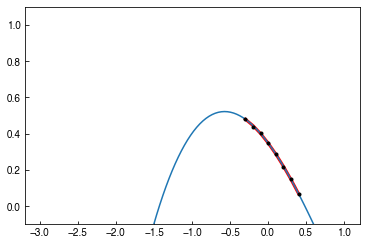

In [6]:
# Now interpolate between points

model_poly = models.Polynomial1D(degree=3)
fitter_poly = fitting.LinearLSQFitter()
best_fit_poly = fitter_poly(model_poly, BBmodel['Fe_H'],BBmodel['H20'])

print(best_fit_poly)

plt.errorbar(BBmodel['Fe_H'],BBmodel['H20'], fmt='k.')
plt.plot(BBmodel['Fe_H'],best_fit_poly(BBmodel['Fe_H']),color='r', linewidth=3)

newxs = np.linspace(-3,1.,100)

plt.plot(newxs, best_fit_poly(newxs))
plt.ylim(-0.1,1.1)

This doesnt look ideal at the low $\mathrm{[Fe/H]}$ end, so we can try some other options here... what about a spline?

(-0.1, 1.1)

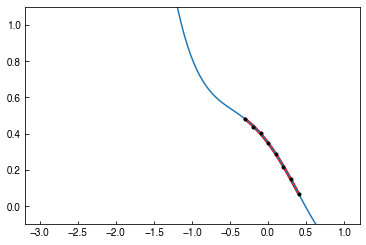

In [18]:
s = UnivariateSpline(BBmodel['Fe_H'],BBmodel['H20'], k=4)


plt.errorbar(BBmodel['Fe_H'],BBmodel['H20'], fmt='k.')
plt.plot(BBmodel['Fe_H'],s(BBmodel['Fe_H']),color='r', linewidth=3)

newxs = np.linspace(-3,1.,100)

plt.plot(newxs, s(newxs))
plt.ylim(-0.1,1.1)

Again, not ideal since the mass fraction can get to above 1 (and below 0....). What actually happens in the data we have for stars?

In [19]:
allstar = apread.allStar(main=True, exclude_star_bad=True, exclude_star_warn=True)

/Users/tedmackereth/anaconda3/lib/python3.7/site-packages/apogee-1.-py3.7.egg/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)


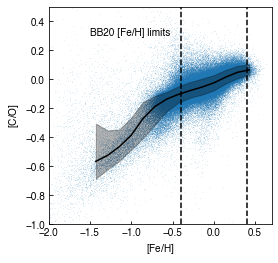

In [16]:
fig = plt.figure()
fig.set_size_inches(4,4)

bad = (allstar['LOGG_ERR'] < 0.1) & (allstar['C_FE'] != -9999.9902) & (allstar['O_FE'] != -9999.9902)



plt.scatter(allstar['FE_H'][bad], allstar['C_FE'][bad]-allstar['O_FE'][bad], s=0.1, lw=0., alpha=0.8, rasterized=True)
plt.xlim(-2.,0.7)
plt.ylim(-1,0.5)

def running_percentile(x, y, bins):
    bin_inds = np.digitize(x, bins)
    values = np.ones((len(bins),3))*np.nan
    for i in np.unique(bin_inds):
        if i == 0 or i == 15:
            continue
        in_bin = bin_inds == i
        if sum(in_bin) < 10:
            continue
        values[i] = np.percentile(y[in_bin], [16,50,84])
    bin_centers = (bins[1:]+bins[:-1])/2.
    return values, bin_centers
        
bins = np.linspace(-1.5,0.5,15)
medians, bin_centers = running_percentile(allstar['FE_H'][bad], allstar['C_FE'][bad]-allstar['O_FE'][bad], bins)  

plt.plot(bins-((bins[1]-bins[0])/2.), medians[:,1], c='Black')
plt.fill_between(bins-((bins[1]-bins[0])/2.), medians[:,0], medians[:,2], color='Black', alpha=0.3)

plt.axvline(-0.4, color='Black', linestyle='dashed')
plt.axvline(0.4, color='Black', linestyle='dashed')
plt.text(-1.5,0.3, 'BB20 [Fe/H] limits')

plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{[C/O]}$')

plt.savefig('../plots/CO_FEH_APOGEEDR16.pdf')

In [41]:
medians

array([        nan, -1.02020454, -0.7870388 , -0.76268303, -0.6453892 ,
       -0.51388556, -0.41236639, -0.2849645 , -0.22141162, -0.16943496,
       -0.14022744, -0.11256003, -0.07213556, -0.02788172,  0.01323642])

In [36]:
np.unique(np.digitize(allstar['FE_H'][bad], bins))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [37]:
len(bins)

15

(-0.2, 0.5)

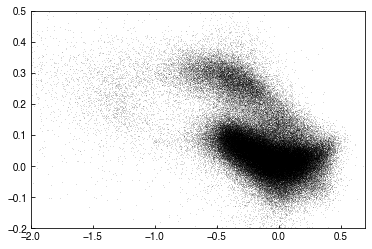

In [28]:
plt.scatter(allstar['FE_H'], allstar['MG_FE'], s=0.1, lw=0., color='Black')
plt.xlim(-2,0.7)
plt.ylim(-0.2,0.5)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                  c1                  c2                  c3        
    ------------------ ------------------- ------------------- -------------------
    0.3480026126904762 -0.5659026289285716 -0.3847110642857163 0.12633408333333815
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                  c1                  c2                  c3        
    ------------------ ------------------- ------------------- -------------------
    0.3480026126904762 -0.5659026289285716 -0.3847110642857163 0.12633408333333815


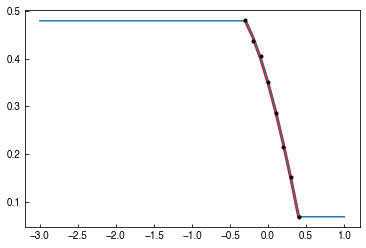

In [4]:
# Now interpolate between points

def piecewise_poly(x):
    model_poly = models.Polynomial1D(degree=3)
    fitter_poly = fitting.LinearLSQFitter()
    best_fit_poly = fitter_poly(model_poly, BBmodel['Fe_H'],BBmodel['H20'])
    print(best_fit_poly)
    minx, maxx = np.min(BBmodel['Fe_H']), np.max(BBmodel['Fe_H'])
    minxy = best_fit_poly(minx)
    maxxy = best_fit_poly(maxx)
    if not hasattr(x, '__iter__'):
        if x < minx:
            return minxy
        elif x > maxx:
            return maxxy
        else:
            return best_fit_poly(x)
    else:
        out = np.zeros(len(x))
        out[x < minx] = minxy
        out[x > maxx] = maxxy
        out[(x >= minx) & (x <= maxx)] = best_fit_poly(x[(x >= minx) & (x <= maxx)])
        return out

plt.errorbar(BBmodel['Fe_H'],BBmodel['H20'], fmt='k.')
plt.plot(BBmodel['Fe_H'],piecewise_poly(BBmodel['Fe_H']),color='r', linewidth=3)

newxs = np.linspace(-3,1.,100)

plt.plot(newxs, piecewise_poly(newxs))

In [5]:
fire = ascii.read('../sav/GalaxyA_FOF507_working.dat')

In [18]:
water_mass_frac = piecewise_poly(fire['fe_h']- np.median(fire['fe_h']))

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                  c1                  c2                  c3        
    ------------------ ------------------- ------------------- -------------------
    0.3480026126904762 -0.5659026289285716 -0.3847110642857163 0.12633408333333815


(array([ 8469.,  1392.,  1491.,  1677.,  1754.,  1980.,  2171.,  2491.,
         2570., 12896.]),
 array([0.06817317, 0.10932969, 0.15048621, 0.19164274, 0.23279926,
        0.27395578, 0.3151123 , 0.35626882, 0.39742534, 0.43858186,
        0.47973839]),
 <a list of 10 Patch objects>)

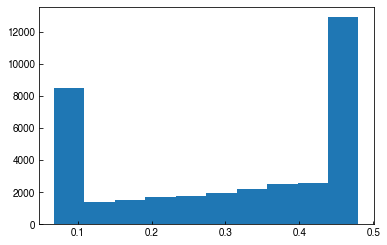

In [22]:
plt.hist(water_mass_frac)

(array([ 149.,  276.,  670., 1461., 3305., 6409., 9041., 8228., 5359.,
        1707.]),
 array([-2. , -1.7, -1.4, -1.1, -0.8, -0.5, -0.2,  0.1,  0.4,  0.7,  1. ]),
 <a list of 10 Patch objects>)

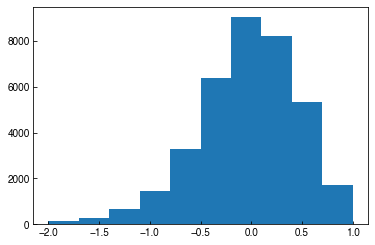

In [20]:
plt.hist(fire['fe_h']-np.median(fire['fe_h']), range=[-2,1.])

In [12]:
np.median(fire['fe_h'])

-0.2149660587310791